In [57]:
import os 
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import pandas as pd
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.4)

import time
import warnings
warnings.filterwarnings('ignore')
!pip install split-folders
!pip install kaggle
import splitfolders
cudnn.benchmark = True
plt.ion()   # interactive mode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:

!kaggle competitions download -c journey-springfield
!unzip journey-springfield.zip

journey-springfield.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  journey-springfield.zip
replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# New Section

In [59]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((int(244 * 1.05), int(244 * 1.05))),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

input_folder = 'train/simpsons_dataset'
splitfolders.ratio(input_folder, 'train_val_data', ratio = (0.75, 0.25), seed=13, group_prefix=None)

data_dir = 'train_val_data'
train_valid_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
        
dataloaders = {'train': torch.utils.data.DataLoader(train_valid_datasets['train'], batch_size=32,
                                             shuffle=True, num_workers=2),
               'val': torch.utils.data.DataLoader(train_valid_datasets['val'], batch_size=32,
                                             shuffle=False, num_workers=2)
              }

dataset_sizes = {x: len(train_valid_datasets[x]) for x in ['train', 'val']}


class_names = train_valid_datasets['train'].classes


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Copying files: 20933 files [00:05, 3952.61 files/s]


cuda:0


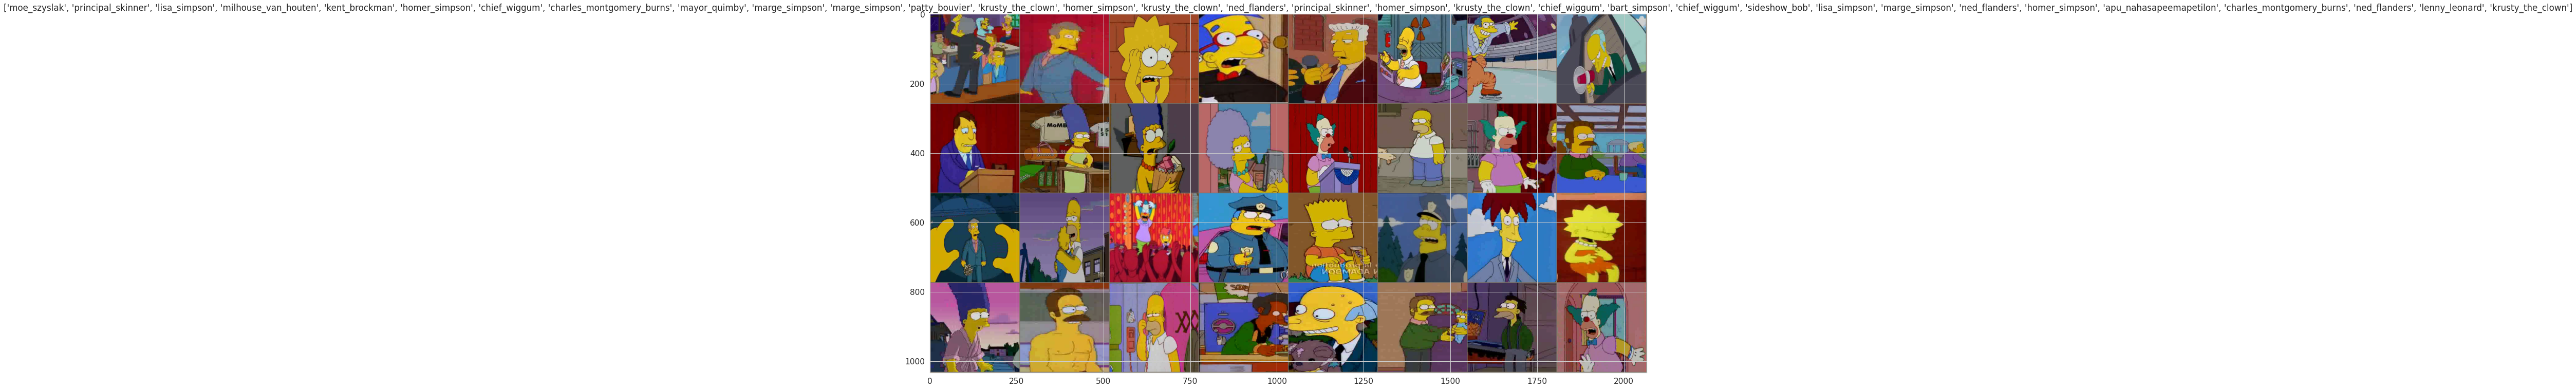

In [60]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(25, 22))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [61]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    '''

    main training code

    '''
    start = time.time()
    
    use_gpu = torch.cuda.is_available()
  
    best_mode_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': [], 'val': []}
    accs = {'train': [], 'val': []}

    pbar = trange(epochs, desc='Epoch')

    for epoch in pbar:

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.eval()

            curr_loss = 0.0
            curr_corrects = 0  

            for data in tqdm(dataloaders[phase], leave=False, desc=f'{phase} iter'):
                inputs, labels = data
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                else:
                    inputs, labels = inputs, labels
        
                if phase == 'train':
                    optimizer.zero_grad()

                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                curr_loss += loss.item()
                curr_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = curr_loss / dataset_sizes[phase]
            epoch_acc = curr_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
  
    time_elapsed = time.time() - start
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best val Acc: {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model, losses, accs

def predict(model, dataloader_test):
    probs = []
    model.eval()
    with torch.no_grad():
        
        for inputs, y in tqdm(dataloader_test):
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                
            preds = model(inputs).cpu()
            probs.append(preds)
            
    print(f'probs shape before softmax: {len(probs)}')
    probs = nn.functional.softmax(torch.cat(probs), dim=-1).numpy()
    print(f'probs shape after softmax: {probs.shape}')
    
    return probs

In [62]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def plot_metrics(losses, accs):
    '''
    
    plots some metrics graphics
    
    '''
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    plt.plot(losses['train'])
    plt.plot(losses['val'])
    plt.title('loss')
    plt.legend(list(losses.keys()))

    plt.subplot(1, 2, 2)
    plt.plot(accs['train'])
    plt.plot(accs['val'])
    plt.title('accuracy')
    plt.legend(list(accs.keys()))

    plt.show()



In [65]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# for param in model_ft.parameters():
#     param.requires_grad = False
    
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-4)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

Epoch:   0%|          | 0/12 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

train iter:   0%|          | 0/491 [00:00<?, ?it/s]

val iter:   0%|          | 0/165 [00:00<?, ?it/s]

Training complete in 106m 60s
Best val Acc: 0.9752


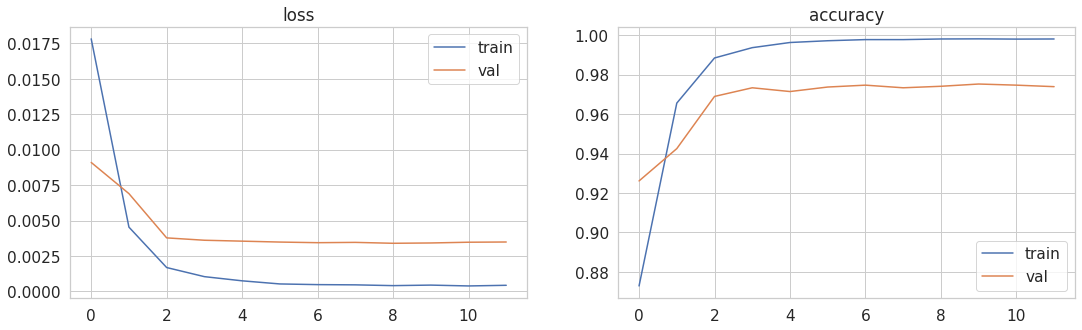

In [66]:
model_ft, losses_resnet, accs_resnet = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, epochs=12)

plot_metrics(losses_resnet, accs_resnet)

In [67]:

transform = transforms.Compose([
    transforms.Resize((int(244 * 1.05), int(244 * 1.05))),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_test = datasets.ImageFolder(
    root='testset/',
    transform=transform
)

dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=32)

test_filenames = [fn[0].split('/')[-1] for fn in dataset_test.imgs]

probs_resnet = predict(model_ft, dataloader_test)
print(probs_resnet.shape)

preds_resnet = np.argmax(probs_resnet, axis=1)
preds = []
for i in range(len(preds_resnet)):
  preds.append(class_names[preds_resnet[i]])

submission = pd.read_csv('sample_submission.csv')
submission = pd.DataFrame({'id': test_filenames, 'Expected': preds}).sort_values('id')
submission.to_csv('./submission.csv', index=False)

submission

  0%|          | 0/31 [00:00<?, ?it/s]

probs shape before softmax: 31
probs shape after softmax: (991, 42)
(991, 42)


,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum
